In [5]:
import torch
import matplotlib.pyplot as plt
import gym
import numpy as np
from scipy.signal import savgol_filter

from REINFORCE import PGAgent

In [2]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 500 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, 
                action_size, 
                hidden_size, 
                actor_lr, 
                value_function_lr, 
                discount)
        

In [3]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
    state, _ = env.reset()
    state_list, action_list, reward_list = [], [], []
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    state_list = []
    action_list = []
    reward_list = []
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()

        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        episode_length += 1

        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        # end episode early
        if total_reward < -250:
            done = 1
        
        if done:
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every), 
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.
            break
        
        state = next_state

c:\Users\david\OneDrive\Documenti\GitHub\Lunar_Lander_DeepRL\Discrete\PG_MC_REINFORCE\REINFORCE.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  state_t = torch.FloatTensor(state_list).to(device)


Episode: 0 Timestep: 59 Total reward: -117.2 Episode length: 59.0 Actor Loss: -0.0980 VF Loss: 0.0497
Episode: 10 Timestep: 1041 Total reward: -196.7 Episode length: 98.2 Actor Loss: -0.1778 VF Loss: 0.2694
Episode: 20 Timestep: 2041 Total reward: -221.6 Episode length: 100.0 Actor Loss: 0.3496 VF Loss: 0.4029
Episode: 30 Timestep: 3038 Total reward: -212.8 Episode length: 99.7 Actor Loss: -0.4686 VF Loss: 0.2892
Episode: 40 Timestep: 4036 Total reward: -234.5 Episode length: 99.8 Actor Loss: 0.0068 VF Loss: 0.4493
Episode: 50 Timestep: 5060 Total reward: -227.2 Episode length: 102.4 Actor Loss: 0.2080 VF Loss: 0.4462
Episode: 60 Timestep: 5918 Total reward: -124.7 Episode length: 85.8 Actor Loss: -0.0574 VF Loss: 0.1512
Episode: 70 Timestep: 6685 Total reward: -228.4 Episode length: 76.7 Actor Loss: -0.4418 VF Loss: 0.4308
Episode: 80 Timestep: 7529 Total reward: -147.7 Episode length: 84.4 Actor Loss: 0.5277 VF Loss: 0.4616
Episode: 90 Timestep: 8324 Total reward: -147.2 Episode leng

Text(0, 0.5, 'Episode Reward')

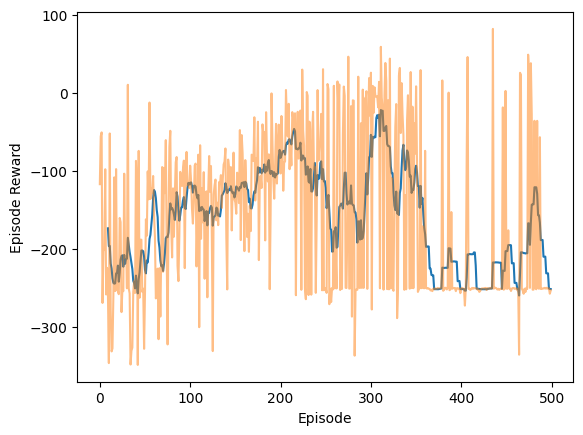

In [10]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

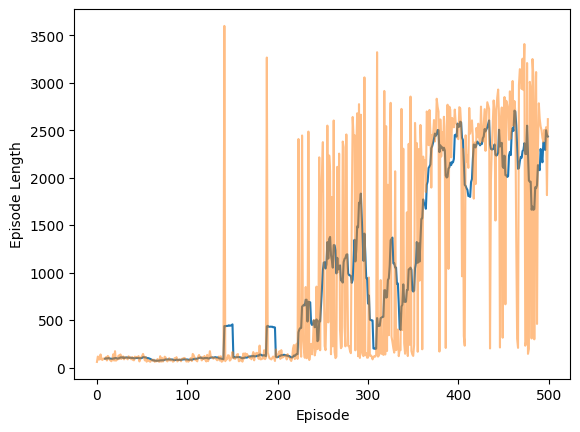

In [11]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')